## Recommender env : implémentation

In [1]:
# HIDDEN
import gym
import numpy as np

#### Mise en œuvre

Nous sommes maintenant prêts à mettre en œuvre notre environnement 

#### Révision : de quoi un env a-t-il besoin ?

Exigences pour un environnement RL :

- Espace d'observation
- Espace d'action
- Constructeur
- méthode `reset()`
- méthode `step()`

Nous allons maintenant créer tous ces éléments pour notre environnement de recommandation. Allons-y !

Notes :

Dans le module précédent, nous avons énuméré les exigences suivantes pour un environnement RL :

#### Espace d'observation

- La première étape consiste à définir l'espace d'observation 
- Nos observations sont les _caractéristiques des articles candidats_.
- Pour simplifier, nous supposerons qu'il n'y a qu'une seule caractéristique.
- Ici, nos observations sont à valeur continue, et non discrète comme Frozen Lake.
- Si tu le souhaites, fais une pause et réfléchis à ce que devrait être l'espace d'observation.
  - Tu peux consulter la documentation de la bibliothèque gym [ici] (https://www.gymlibrary.ml/content/spaces/).

In [2]:
# TODO
# we could have a multiple choice in here
# I guess it's potentially fine to have tons of short notebooks in this module???
# might be a bit of a hassle for video recording?

#### Espace d'observation

- Nous voulons l'espace `Box` :

In [3]:
# HIDDEN
num_candidates=10

In [4]:
observation_space = gym.spaces.Box(low=0, high=1, shape=(num_candidates,))

- Les caractéristiques sont comprises entre 0 et 1, le nombre de caractéristiques correspond au nombre de candidats aux postes 
- Voici un échantillon de l'espace d'observation :

In [5]:
observation_space.sample()

array([0.84231544, 0.79355806, 0.90070623, 0.17489515, 0.85802037,
       0.26228273, 0.88349086, 0.4622379 , 0.77141196, 0.37806642],
      dtype=float32)

Ça a l'air bien 👍

#### Espace d'action

- Dans cet environnement, l'action est l'élément choisi pour recommander.
- Si tu le souhaites, fais une pause et réfléchis à ce que devrait être l'espace d'action.
  - Tu peux consulter la documentation de la bibliothèque de gymnastique [ici] (https://www.gymlibrary.ml/content/spaces/).

#### Espace d'action

Contrairement à l'espace d'observation, l'espace d'action _est_ discret :

In [6]:
action_space = gym.spaces.Discrete(num_candidates)

Voici 15 actions choisies au hasard :

In [7]:
[action_space.sample() for i in range(15)]

[9, 4, 5, 4, 5, 1, 6, 8, 7, 6, 8, 8, 6, 1, 7]

Ça a l'air bien 👍

#### Constructeur

Commençons par le constructeur :

In [8]:
class BasicRecommender(gym.Env):
    def __init__(self, env_config=None):
        # Set parameters    
        self.num_candidates = env_config.get("num_candidates", 10)
        self.alpha = env_config.get("alpha", 0.9)

        # Set observation and action spaces
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(self.num_candidates,))
        self.action_space = gym.spaces.Discrete(self.num_candidates)

Notes :

Les espaces d'observation et d'action suivent ce que nous avons vu dans le diaporama précédent 

_COPY #### Reset

Ensuite, nous avons besoin de notre méthode `reset()`, qui doit :

- Réinitialiser le niveau de sucre
- Echantillonner/simuler des caractéristiques aléatoires du document
- Renvoyer l'observation 

In [9]:
class BasicRecommender(gym.Env):

    def reset(self):
        self.sugar_level = 0.0                
        self.documents = np.random.rand(self.num_candidates)
        return self.documents

Notes :

Nous réinitialiserons le niveau de sucre à zéro, mais d'autres choix pourraient également être raisonnables. Pour simplifier, nous ferons également en sorte que les caractéristiques soient comprises entre 0 et 1, et nous les choisirons uniformément au hasard. Encore une fois, ce sont tous des choix que nous faisons pour modéliser la situation réelle. Nous optons pour les choix les plus simples à des fins pédagogiques.

#### Étape

- Comme d'habitude, la méthode `step()` est la plus compliquée.
- Cependant, nous pouvons utiliser nos fonctions `update_sugar_level` et `reward` de tout à l'heure.
- Pour rappel, les voici à nouveau :

In [10]:
def update_sugar_level(self, item_sweetness):
    self.sugar_level = self.alpha * self.sugar_level + (1 - self.alpha) * item_sweetness

In [11]:
def reward(self, item_sweetness):
    return item_sweetness * (1 - self.sugar_level)

Notes :

Nous avons apporté de légères modifications car l'alpha et le niveau de sucre sont maintenant stockés dans la classe en tant que self.alpha et self.sugar_level plutôt que d'être passés dans les fonctions 

#### Étape

Et maintenant pour `step()`, qui doit :

- Calculer la récompense
- Mettre à jour le niveau de sucre
- Simuler un ensemble de nouveaux éléments candidats pour la prochaine itération
- Renvoie l'observation, la récompense et le drapeau "done

In [12]:
    def step(self, action):

        # Get the sweetness of the recommended item
        item_sweetness = self.documents[action]

        # Compute reward
        reward = self.reward(item_sweetness)

        # Update sugar level
        self.update_sugar_level(item_sweetness)

        # Generate new candidates for the next recommendation
        if self.resample_documents:
            self.documents = np.random.rand(self.num_candidates)

        # Set the done flag (not shown for brevity)
        done = False
            
        return self.documents, reward, done, {"sugar_level" : self.sugar_level}

Notes :

Quelques points à noter ici. Pour l'instant, nous retournons toujours done=False. En réalité, nous définirons un nombre maximum fixe d'étapes avant que l'épisode ne se termine, comme indiqué dans le module précédent. Cependant, nous ne le montrons pas ici pour des raisons de brièveté.
Note également que la méthode `step` renvoie le niveau de sucre. L'agent n'y accède pas, mais c'est juste pour notre commodité lorsque nous déboguons/introspectons le système RL. Auparavant, nous avions simplement ignoré cette information facultative renvoyée par `step`.

#### Testons-le !

Testons notre nouvel environnement !

In [13]:
# HIDDEN
from envs_04 import BasicRecommender

In [14]:
env_config = {
    "num_candidates" : 2,
    "alpha"          : 0.5,
    "seed"           : 42
}

In [15]:
env = BasicRecommender(env_config)

Notes 

Nous définirons le nombre de candidats à 2 pour faciliter l'illustration par la suite, et l'alpha par défaut à 0,5, ce qui signifie que le nouveau taux de sucre est mis à jour pour être la moyenne (non pondérée) de l'ancien taux de sucre et de la douceur de l'article 

Nous avons défini la graine aléatoire à 0 pour la reproductibilité 

#### Testons-le !

In [16]:
# HIDDEN
# env.seed(42)

In [17]:
env.reset()

array([0.37454012, 0.95071431])

- Cela semble bon.
- Comme nous avons défini `num_candidats` à 2 dans `env_config`, nous voyons 2 candidats.
- Chacun des chiffres ci-dessus représente la douceur d'un candidat d'article simulé.
- Demandons à l'agent de sélectionner (recommander) le premier article, avec une douceur de 0,37.

In [18]:
env.step(0)

(array([0.73199394, 0.59865848]),
 0.3745401188473625,
 False,
 {'sugar_level': 0.18727005942368125})

Notes :

Nous pouvons observer que le niveau de sucre est passé de 0 à 1-alpha, soit 0,5 fois la douceur de l'article de 0,37. Pour rappel, l'info sur le niveau de sucre n'est pas disponible pour l'agent, elle est juste pour nous. Note également que, après notre action, un nouvel ensemble de documents candidats est donné comme observation.

#### Ligne de base

Avant de former notre agent, établissons d'abord deux lignes de base :

- Ligne de base avide : toujours choisir l'article le plus doux
- Ligne de base aléatoire : choisis au hasard à chaque fois

#### Ligne de base gourmande

In [19]:
env = BasicRecommender(env_config)

def greedy_agent_episode(env):
    obs = env.reset()
    total_reward = 0
    done = False
    while not done:
        sweetest_item = np.argmax(obs)
        obs, reward, done, info = env.step(sweetest_item)
        total_reward += reward
    return total_reward

En raison du caractère aléatoire des valeurs de douceur des articles, nous devons répéter cette opération pour de nombreux épisodes et prendre la moyenne :

In [20]:
np.mean([greedy_agent_episode(env) for episode in range(1000)])

23.07949173189309

- Nous pouvons obtenir une récompense de 23,1 en choisissant toujours les articles les plus doux.
- Pour rendre cela plus excitant, suppose que cela représente 23,1 $ pour notre entreprise, et que nous avons 1M d'utilisateurs, donc 23,1M $.

Notes :

C'est le total pour 100 pas de temps, soit environ 0,23 $ par pas de temps. Si nous avions des épisodes plus longs, ce chiffre serait plus important.

#### Ligne de base aléatoire

Essayons maintenant une approche aléatoire :

Notes 

Ici, l'agent recommande à chaque fois un élément aléatoire parmi les 10 candidats.

In [21]:
env = BasicRecommender(env_config)

def random_agent_episode(env):
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        random_item = np.random.randint(len(obs))
        obs, reward, done, info = env.step(random_item)
        total_reward += reward
    return total_reward

En raison du caractère aléatoire, nous devrions répéter cela pour de nombreux épisodes et prendre la moyenne :

In [22]:
np.mean([random_agent_episode(env) for episode in range(1000)])

25.525709661431282

- Avec des actions aléatoires, nous faisons mieux : environ 25,5 millions de revenus.
- Il est temps de me verser une prime ! 💰

#### Appliquons ce que nous avons appris !

## Améliorer le modèle de l'utilisateur
<!-- multiple choice -->

Nous avons créé un modèle/simulation d'utilisateur très simple pour cet exemple. Lequel des éléments suivants ne serait **PAS** une extension raisonnable de notre modèle utilisateur pour un système de recommandation ?

- [ ] Augmenter le nombre de caractéristiques que nous utilisons pour représenter chaque élément candidat.
- [ ] Tenir compte des caractéristiques de chaque utilisateur plutôt que de traiter tous les utilisateurs de la même façon.
- [ ] Saisis l'interaction des utilisateurs de manière plus riche, par exemple les articles sur lesquels ils cliquent ou qu'ils consomment/achètent.
- [ ] Simule les neurones du cerveau de l'utilisateur et la façon dont ils réagissent aux recommandations d'articles.

## Cupide vs. aléatoire
<!-- multiple choice -->

Ci-dessus, nous avons vu que notre ligne de base aléatoire surpasse notre ligne de base gourmande. Penses-tu que ce sera toujours le cas ?

- [ ] La stratégie aléatoire est toujours plus performante que la stratégie avide. | Et si l'épisode ne comportait qu'une seule étape ?
- [La stratégie avide est toujours plus performante que la stratégie aléatoire. | La stratégie aléatoire a cependant fait mieux.
- [ ] La stratégie aléatoire est plus performante que la stratégie gourmande lorsque la durée de l'épisode augmente. | La stratégie avide fonctionne à court terme, mais pas à long terme.
- [ ] La stratégie gourmande est plus performante que la stratégie aléatoire lorsque la durée de l'épisode augmente. | Je pense que tu as fait les choses à l'envers.

## Greedy vs. random continued
<!-- coding exercise -->

Dans la question précédente, nous avons décidé que la stratégie aléatoire devrait être plus performante pour les épisodes longs mais que la méthode avide pourrait être meilleure pour les épisodes courts. Par exemple, si l'épisode entier n'est composé que d'une seule recommandation, nous voulons simplement l'élément le plus doux. Teste cette relation de façon empirique en remplissant le code manquant 

In [23]:
# EXERCISE

import numpy as np
import matplotlib.pyplot as plt
from envs_04 import BasicRecommender

def baseline_episode(env, method="greedy"):
    """
    Compute the episode reward for a BasicRecommender env by either
    acting greedy (max observation) or acting randomly.
    Return total reward.
    """
    obs = env.reset()
    total_reward = 0
    done = False
    while not done:
        if method == "greedy":
            chosen_item = np.argmax(____)
        elif method == "random":
            chosen_item = np.random.randint(____)
        else:
            raise Exception("Unknown method.")
        obs, reward, done, info = env.____(chosen_item)
        total_reward += reward
    return total_reward

def baseline_multiple_episodes(env, method, n_ep=100):
    """ Compute baseline reward averaged over multiple episodes """
    return np.mean([baseline_episode(env, method) for ep in range(n_ep)])

max_steps = [1,3,10,30,100] # The different horizon lengths to test out
greedy_results = []
random_results = []

# Run the simulations
for ms in ____:
    env = BasicRecommender({"max_steps" : ____})
    greedy_results.append(baseline_multiple_episodes(env, "greedy"))
    random_results.append(baseline_multiple_episodes(env, "random"))
    
# Plotting code (you can ignore)
plt.plot(max_steps, greedy_results, label="greedy")
plt.plot(max_steps, random_results, label="random")
plt.legend();
plt.xlabel("horizon of the env");
plt.ylabel("episode reward");

NameError: name '____' is not defined

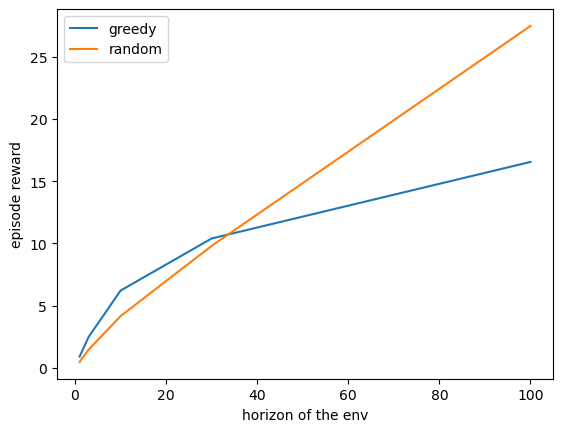

In [24]:
# SOLUTION

import numpy as np
import matplotlib.pyplot as plt
from envs_04 import BasicRecommender

def baseline_episode(env, method="greedy"):
    """
    Compute the episode reward for a BasicRecommender env by either
    acting greedy (max observation) or acting randomly.
    Return total reward.
    """
    obs = env.reset()
    total_reward = 0
    done = False
    while not done:
        if method == "greedy":
            chosen_item = np.argmax(obs)
        elif method == "random":
            chosen_item = np.random.randint(len(obs))
        else:
            raise Exception("Unknown method.")
        obs, reward, done, info = env.step(chosen_item)
        total_reward += reward
    return total_reward

def baseline_multiple_episodes(env, method, n_ep=100):
    """ Compute baseline reward averaged over multiple episodes """
    return np.mean([baseline_episode(env, method) for ep in range(n_ep)])

max_steps = [1,3,10,30,100] # The different horizon lengths to test out
greedy_results = []
random_results = []

# Run the simulations
for ms in max_steps:
    env = BasicRecommender({"max_steps" : ms})
    greedy_results.append(baseline_multiple_episodes(env, "greedy"))
    random_results.append(baseline_multiple_episodes(env, "random"))
    
# Plotting code (you can ignore)
plt.plot(max_steps, greedy_results, label="greedy")
plt.plot(max_steps, random_results, label="random")
plt.legend();
plt.xlabel("horizon of the env");
plt.ylabel("episode reward");

#### Interpréter l'intrigue

Quelle est l'interprétation de l'intrigue ?

- [ ] Comme prévu, l'agent aléatoire surpasse l'agent avide de plus en plus à mesure que la longueur de l'épisode augmente.
- [ ] Quelque chose s'est horriblement mal passé, et l'effet ci-dessus n'a pas été observé.